In [1]:
import tarfile
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import multiprocessing

# Note:
Inside the data/ directory, link atmens directories as: 

ln -sf /home/dao_ops/e5303_m21c_jan98/run/.../archive/atmens/  m21c_ens_strm1 

ln -sf /home/dao_ops/e5303_m21c_jan08/run/.../archive/atmens/  m21c_ens_strm2

ln -sf /home/dao_ops/e5303_m21c_jan18/run/.../archive/atmens/  m21c_ens_strm3


In [2]:
def get_target_file(date_in_tar):

    #For now DO include spinup year  
    year = date_in_tar.year
    if year < 2007 :
        strm = 'm21c_ens_strm1'
        expid = 'e5303_m21c_jan98'
    elif year >= 2007 and year < 2017:
        strm = 'm21c_ens_strm2'
        expid = 'e5303_m21c_jan08'
    else:
        strm = 'm21c_ens_strm3'
        expid = 'e5303_m21c_jan18' 
    
    # Files 
    var_file_prefix = f"{expid}.bkg.eta"
    tar_file_prefix = f"{expid}.atmens_stat"
    
    tar_file_template = f"../data/{strm}/Y%Y/M%m/{tar_file_prefix}.%Y%m%d_%Hz.tar"
    
    parentdir = date_in_tar.strftime(f"{tar_file_prefix}.%Y%m%d_%Hz")

    target_datetime = date_in_tar + timedelta(hours=3)
    target_file_name = target_datetime.strftime(f"{parentdir}/ensrms/{var_file_prefix}.%Y%m%d_%H00z.nc4")

    return tar_file_template, target_file_name

def get_variables():    
    var3d_list = ['tv', 'u', 'v', 'sphu', 'ozone']
    var2d_list = ['ps'] # Check if ts can be added here.

    return var3d_list, var2d_list

In [3]:
def read_netcdf_from_tar_netcdf4(tar_file, date_in_tar, target_file_name):
    with tarfile.open(tar_file, 'r') as tar:
        try:
            if target_file_name in tar.getnames():
                tar_file = tar.extractfile(target_file_name)
                if tar_file is None:
                    print(f"File '{target_file_name}' not found in {tar_file}")
                    return None

                with nc.Dataset('inmemoryfile', memory=tar_file.read()) as ds:
                    # 
                    xr_ds = xr.open_dataset(xr.backends.NetCDF4DataStore(ds))
                    xr_ds.load()  
                    return xr_ds
            else:
                print(f"File '{target_file_name}' not found in {tar_file}")
                return None
        except Exception as e:
            print(f"Error reading '{target_file_name}': {e}")
            return None

In [4]:
def process_tar_file_2d3d(tar_file, date_in_tar, target_file_name, var3d_list, var2d_list):
    """
    Process a single tar file and return the lat-lon average for 3D variables,
    and longitude-only average for 2D variables, along with the corresponding time.
    """
    ds = read_netcdf_from_tar_netcdf4(tar_file, date_in_tar, target_file_name)
    if ds is None:
        return None, None

    latlon_avg_results = {}  # Dictionary to hold results for each variable
    time_coord = ds['time'].values[0]  # Get the time coordinate (assumes 'time' dimension is present)

    # Process 3D variables: Average over latitude and longitude
    for var in var3d_list:
        if var in ds:
            spread_data = ds[var]
            latlon_avg = spread_data.mean(dim=["lat", "lon"])
            latlon_avg_results[var] = latlon_avg

    # Process 2D variables: Average over longitude only
    for var in var2d_list:
        if var in ds:
            spread_data = ds[var]
            lon_avg = spread_data.mean(dim="lon")  # Average over longitude only
            latlon_avg_results[var] = lon_avg

    return latlon_avg_results, time_coord

In [5]:
def parallel_process_files_2d3d(start_date, end_date, var3d_list, var2d_list, num_workers=4):   
    current_date = start_date
    tar_files = []

    while current_date <= end_date:
        tar_file_template, target_file_name = get_target_file(current_date)
        tar_file_path = current_date.strftime(tar_file_template)
        tar_files.append((tar_file_path, current_date, target_file_name))
        current_date += timedelta(hours=6)

    # Use multiprocessing to process files in parallel
    with multiprocessing.Pool(num_workers) as pool:
        results = pool.starmap(process_tar_file_2d3d, [(tar_file, date, target_file_name, var3d_list, var2d_list) for tar_file, date, target_file_name in tar_files])

    # Filter out None results (in case some tar files were missing)
    valid_results = [result for result in results if result[0] is not None]

    # Initialize dictionaries to hold combined results for each variable
    combined_averages = {var: [] for var in var3d_list + var2d_list}
    time_coords = []

    # Accumulate the results for each variable separately
    for avg_dict, time_coord in valid_results:
        for var, avg in avg_dict.items():
            combined_averages[var].append(avg)
        time_coords.append(time_coord)

    # Convert time coordinates into a numpy array
    time_coords = np.array(time_coords)

    # Combine the results for each variable into a DataArray, along the time dimension
    for var in combined_averages:
        combined_averages[var] = xr.concat(combined_averages[var], dim='time')
        combined_averages[var]['time'] = time_coords  # Assign time coordinates

    return combined_averages

In [14]:

def plot_hovmoeller_3d(latlon_avg: xr.DataArray, var):
    """
    Plot the Hovmöller diagram (lat-lon averaged ensemble spread over time and vertical levels).
    """
    time = latlon_avg['time'].values
    vertical_levels = latlon_avg['lev'].values
    spread_data = latlon_avg.values

    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    levels = np.linspace(0, 2.5, 32)  # 
    
    # Create contour plot with fixed color range
    cf = plt.contourf(time, vertical_levels, spread_data.T, 
                     cmap='YlGnBu', 
                     levels=levels,
                     extend='max')  # 'extend' handles values beyond the range
    
    # Add colorbar with specified range
    cbar = plt.colorbar(cf, label='(m/s)')
    
    # Set axis labels and title
    plt.xlabel('Time')
    plt.ylabel('Vertical Levels')
    plt.title(f'Ensemble Spread - {var}')
    
    # Adjust time axis to be less crowded
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 2 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Year-Month format
    
    # Optional: Add minor ticks for months in between
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Rotate and align the tick labels so they look better
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
#    plt.yscale('log')
    
    # Fix the x-axis to show readable time labels
#    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
#    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
#    plt.gcf().autofmt_xdate()  
    plt.gca().invert_yaxis()
    
    plt.savefig(f'../plots/M21C_EnsSpread_hovm_{var}_{year}.png')
    plt.show()
    

    


In [15]:
def plot_hovmoeller_2d(lon_avg: xr.DataArray, var):
    """
    Plot the Hovmöller diagram (zonally averaged ensemble spread over time and latitudes ).
    """
    time = lon_avg['time'].values
    latitudes = lon_avg['lat'].values
    spread_data = lon_avg.values

    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set specific levels for colorbar
    levels = np.linspace(0, 250, 32)  # 
    
    # Create contour plot with fixed color range
    cf = plt.contourf(time, latitudes, spread_data.T, 
                     cmap='YlGnBu', 
                     levels=levels,
                     extend='max')  # 'extend' handles values beyond the range
    
    # Add colorbar with specified range
    cbar = plt.colorbar(cf, label='[Unit]')
    
    # Set axis labels and title
    plt.xlabel('Time')
    plt.ylabel('Latitudes')
    plt.title(f'Ensemble Spread - {var}')
    
    # Adjust time axis to be less crowded
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 1 month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Year-Month format
    
    # Optional: Add minor ticks for months in between
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Rotate and align the tick labels so they look better
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save and show
    plt.savefig(f'../plots/M21C_EnsSpread_hovm_{var}_{year}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [10]:
# Example main script
start_date = datetime(2018, 6, 1, 21)
end_date = datetime(2018, 9, 30, 21)
year = start_date.year

var3d_list, var2d_list = get_variables()

var3d_list = ['u']
var2d_list = ['ps']

# Process the files and accumulate lat-lon averages in parallel
combined_averages = parallel_process_files_2d3d(start_date, end_date, var3d_list, var2d_list)


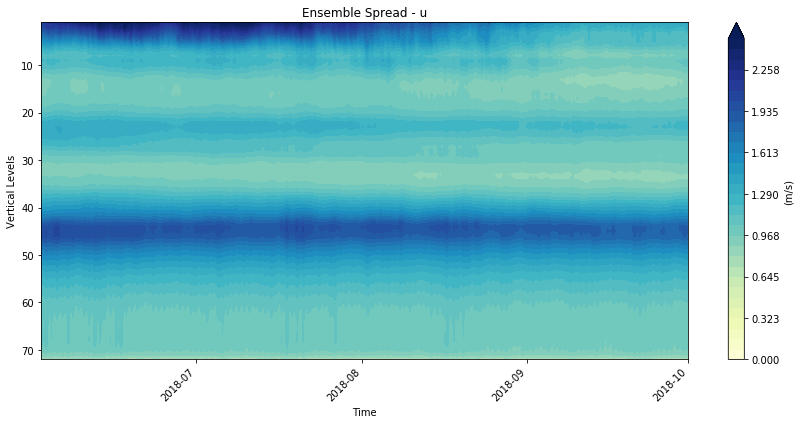

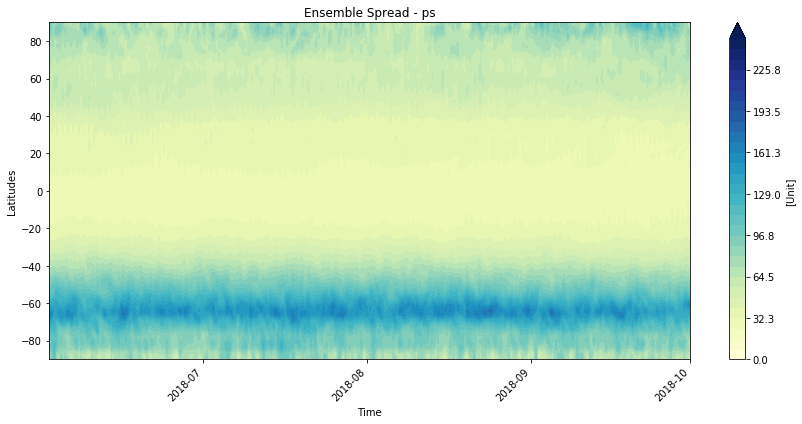

In [16]:

plot_hovmoeller_3d(combined_averages['u'], var='u')
plot_hovmoeller_2d(combined_averages['ps'], var='ps')
